In [1]:
import keras
from keras.models import load_model
from keras.preprocessing import image
import numpy as np
from keras.applications.vgg16 import preprocess_input
import matplotlib as plt

Using TensorFlow backend.


In [2]:
from volume_estimator import VolumeEstimator 

import sys
import json
from keras.models import Model, model_from_json
from food_volume_estimation.depth_estimation.custom_modules import *
from food_volume_estimation.food_segmentation.food_segmentator import FoodSegmentator
import matplotlib.pyplot as plt
from pyntcloud import PyntCloud

# Paths to model archiecture/weights
depth_model_architecture = 'C:\\food_volume_estimation-master\\food_volume_estimation\\monovideo_fine_tune_food_videos.json'
depth_model_weights = 'C:\\food_volume_estimation-master\\food_volume_estimation\\monovideo_fine_tune_food_videos.h5'
segmentation_model_weights = 'C:\\food_volume_estimation-master\\food_volume_estimation\\mask_rcnn_food_segmentation.h5'

# Create estimator object and intialize
estimator = VolumeEstimator(arg_init=False)
with open(depth_model_architecture, 'r') as read_file:
    custom_losses = Losses()
    objs = {'ProjectionLayer': ProjectionLayer,
            'ReflectionPadding2D': ReflectionPadding2D,
            'InverseDepthNormalization': InverseDepthNormalization,
            'AugmentationLayer': AugmentationLayer,
            'compute_source_loss': custom_losses.compute_source_loss}
    model_architecture_json = json.load(read_file)
    estimator.monovideo = model_from_json(model_architecture_json, custom_objects=objs)
estimator._VolumeEstimator__set_weights_trainable(estimator.monovideo, False)
estimator.monovideo.load_weights(depth_model_weights)
estimator.model_input_shape = estimator.monovideo.inputs[0].shape.as_list()[1:]
depth_net = estimator.monovideo.get_layer('depth_net')
estimator.depth_model = Model(inputs=depth_net.inputs, outputs=depth_net.outputs, name='depth_model')
print('[*] Loaded depth estimation model.')

C:\Users\Jay Chothani\.conda\envs\food_volume_estimmation\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


[*] VolumeEstimator not initialized.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use the `axis` argument instead
Instructions for updating:
Use tf.cast instead.
[*] Loaded depth estimation model.


In [3]:
# Depth model configuration
MIN_DEPTH = 0.01
MAX_DEPTH = 10
estimator.min_disp = 1 / MAX_DEPTH
estimator.max_disp = 1 / MIN_DEPTH
estimator.gt_depth_scale = 0.35 # Ground truth expected median depth

In [4]:
# Create segmentator object
estimator.segmentator = FoodSegmentator(segmentation_model_weights)

# Set plate adjustment relaxation parameter
estimator.relax_param = 0.01

[*] Loading segmentation model weights C:\food_volume_estimation-master\food_volume_estimation\mask_rcnn_food_segmentation.h5


In [5]:
#loading vgg16 classification model which is trained on segmented images
#change path with your classification model
model_classifier = load_model(r'C:\Users\Jay Chothani\study\TERM 3\Capstone\full pipe line\masked_classification_vgg16.h5')

Instructions for updating:
Use tf.cast instead.


In [6]:
import cv2
import numpy as np
from mrcnn.config import Config
from mrcnn.model import MaskRCNN

# Define configuration for the model
class InferenceConfig(Config):
    # Give the configuration a recognizable name
    NAME = "segmentation_of_food"

    # Set batch size to 1 since we're running inference on a single image
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    # Number of classes (including background)
    NUM_CLASSES = 2  # 1 Background + 1 Object

# Create config object
config = InferenceConfig()

# Create Mask R-CNN model in inference mode
model_seg = MaskRCNN(mode="inference", config=config, model_dir="./logs")

# Loading pre-trained weights for segmentation of food images
model_seg.load_weights(segmentation_model_weights, by_name=True)
clusters = ['food']
class_names = ['bg'] + clusters

In [7]:
def predict(path = None,field_of_view= 70,dia = 0,plot_results=False,food = None):

    # Estimate volumes in input image
    input_image = path
    plate_diameter = dia # Set as 0 to ignore plate detection and scaling(diameter is in meter)
    
    #if which food is there in image is not given it will detect foods
    if food==None:
        image = cv2.imread(path, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        #segmenting food items from a given image
        results = model_seg.detect([image], verbose=0)
        r = results[0]
        out_put = [] #list of detected images
        
        #creating list of detected images
        for i in range(r["rois"].shape[0]):
            #creating masked image from given result of segmentation model
            masked_image = cv2.bitwise_and(image, image, mask=r["masks"][:,:,i].astype(np.uint8))
            masked_image = cv2.resize(masked_image,(224,224))
            out_put.append(masked_image)
            
        #predicting segmented food image's class
        lable = [] #segmented image's class
        for i in out_put:
            #preprocess image
            img_array = np.expand_dims(i, axis=0)
            img_array = preprocess_input(img_array)
            
            #predicting image class using classification model
            result  = model_classifier.predict(img_array)
            
            #classes in classification model
            classes =  ['alloo_matar', 'apple', 'banana', 'bhindi', 'carrot', 'cucumber', 'dal makhni', 'fried rice', 'Jalebi', 'orange', 'pizza', 'roti', 'samosa']
            
            #taking maximum probability as a output class
            res = np.argmax(result)
            lable.append(classes[res])
            
            
        #estimating volume of each segmented images
        outputs_list = estimator.estimate_volume(input_image, fov=field_of_view, plate_diameter_prior=plate_diameter, 
                                                 plot_results=plot_results,lable=lable)
    
    #if food lable is given before than it will not classify food and just estimate volume
    else: 
        outputs_list = estimator.estimate_volume(input_image, fov=field_of_view, plate_diameter_prior=plate_diameter, 
                                                 plot_results=plot_results,lable=food)
        lable=[food]
    
    #creating list of volumes of food objects in image
    #if plot_result is true it will give index of images and other things in output_list so we will remove every thing 
    #and taking out volumes only
    if plot_results:
        out = []
        for i in range(len(outputs_list)):
            out.append(outputs_list[i][0])
            
    #else it will give only volumes
    else:
        out = outputs_list
        
    
    #weight and calories estimation  
    
    Calories = {} #dictionary for Calories 
    weights = {} #dictionary for weights
    
    #loading data of calories and weight
    calaroies = pd.read_csv(r"C:\Users\Jay Chothani\study\TERM 3\Capstone\Calories.csv")
    
    #if food was not defined 
    if food==None:
        
        # it will itterate all over volume outputs
        for i in range(len(out)):
            vol = out[i]*1000000
            
            #finding food index into data_frame
            ind = list(calaroies.loc[calaroies.name==lable[i]].index)[0]
            
            #weight equal to density multiply by volume 
            wei = calaroies.density[ind] * vol
            
            #calory equals to weight multiply by calories per unit weight
            #calories in data is per 100gms of food so devide weight by 100
            calory = (wei/100)*calaroies.cal[ind]
            
            #we are taking food with weight greater than 10gms to remove unnecessary items
            if wei>10:
                
                #saving weight and calories into dictionary 
                if lable[i] in Calories.keys(): 
                    Calories[lable[i]] += calory
                    weights[lable[i]] += wei
                else:
                    Calories[lable[i]] = calory
                    weights[lable[i]] = wei
                    
    # if food lable was given by user
    else:
        
        #finding index of food item in dataset
        ind = list(calaroies.loc[calaroies.name==lable[0]].index)[0]
        
        #loop will itterate through all volume in output
        for i in range(len(out)):
            vol = out[i]*1000000
            #weight equal to density multiply by volume 
            wei = calaroies.density[ind] * vol
            
            #calory equals to weight multiply by calories per unit weight
            #calories in data is per 100gms of food so devide weight by 100
            calory = (wei/100)*calaroies.cal[ind]
            
            #we are taking food with weight greater than 10gms to remove unnecessary items
            if wei>10:
                
                #saving weight and calories into dictionary 
                if lable[0] in Calories.keys(): 
                    Calories[lable[0]] += calory
                    weights[lable[0]] += wei
                else:
                    Calories[lable[0]] = calory
                    weights[lable[0]] = wei
    
    #total calories is equal to sum of values of calories dictionary 
    total_cal = np.sum(list(Calories.values()))
    
    #total calories is equal to sum of values of weights dictionary 
    total_weight = np.sum(list(weights.values()))
    
    print("total Calories your are goint to intake is",round(total_cal,2),"cal")
    print("total weight of food is",round(total_weight,2),"gms")
    
    return Calories,weights
    

Found 2 food object(s) in image.
Estimated volume: 0.44161648946403 L


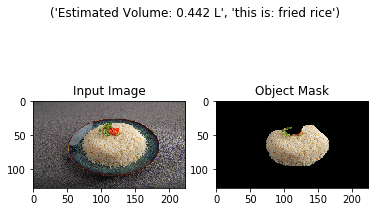

Estimated volume: 0.012651256229392583 L


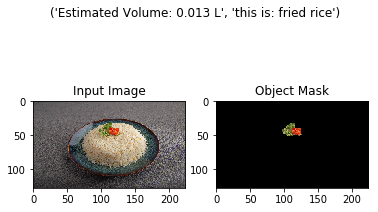

total Calories your are goint to intake is 817.68 cal
total weight of food is 408.84 gms


({'fried rice': 817.6819422481607}, {'fried rice': 408.84097112408034})

In [8]:
predict(r"C:\Users\Jay Chothani\Downloads\pexels-ahmed-agili-14518996.jpg",plot_results=True)

Found 2 food object(s) in image.
Estimated volume: 0.44161648946403 L


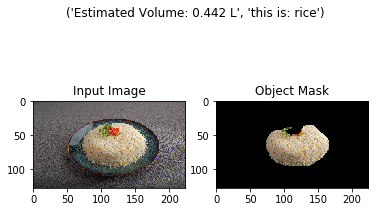

Estimated volume: 0.012651256229392583 L


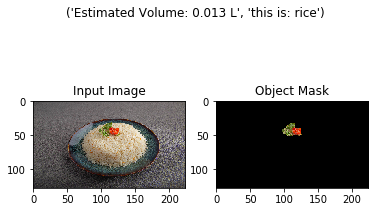

total Calories your are goint to intake is 260.55 cal
total weight of food is 220.81 gms


({'rice': 260.5537287837777}, {'rice': 220.808244732015})

In [9]:
predict(r"C:\Users\Jay Chothani\Downloads\pexels-ahmed-agili-14518996.jpg",plot_results=True,food="rice")

C:\Users\Jay Chothani\.conda\envs\food_volume_estimmation\lib\site-packages\food_volume_estimation-0.3-py3.6.egg\food_volume_estimation\ellipse_detection\ellipse_estimator.py:68: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Jay Chothani\.conda\envs\food_volume_estimmation\lib\site-packages\food_volume_estimation-0.3-py3.6.egg\food_volume_estimation\ellipse_detection\ellipse.py:81: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\Jay Chothani\.conda\envs\food_volume_estimmation\lib\site-packages\food_volume_estimation-0.3-py3.6.egg\food_volume_estimation\ellipse_detection\ellipse_estimator.py:69: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Jay Chothani\.conda\envs\food_volume_estimmation\lib\site-packages\food_volume_estimation-0.3-py3.6.egg\food_volume_estimation\ellipse_detection\ellipse_merger.py:40: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\Jay Chothani\.conda\envs\food_volume_estimmati

Found 3 food object(s) in image.
Estimated volume: 0.0554078943761176 L


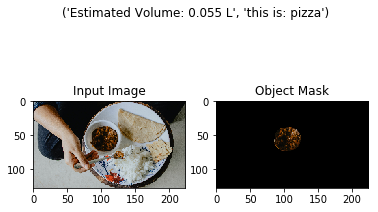

Estimated volume: 0.27103043606952326 L


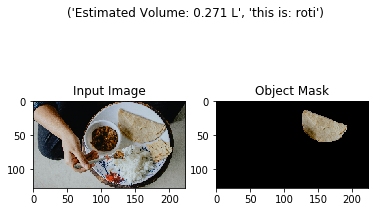

Estimated volume: 0.014775859667857518 L


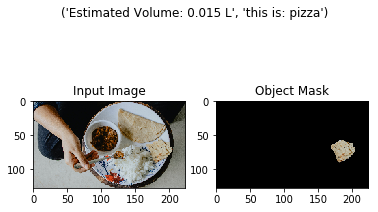

total Calories your are goint to intake is 652.94 cal
total weight of food is 255.91 gms


({'pizza': 144.75399271569867, 'roti': 508.18206763035613},
 {'pizza': 52.637815532981335, 'roti': 203.27282705214245})

In [11]:
predict(r"C:\Users\Jay Chothani\Downloads\pexels-vivaan-rupani-7351635.jpg",plot_results=True)

Found 2 food object(s) in image.
Estimated volume: 0.2507605791183701 L


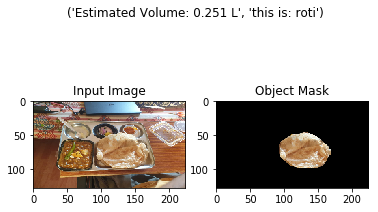

Estimated volume: 0.05566438671289287 L


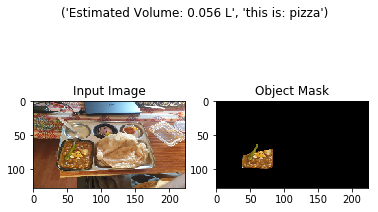

total Calories your are goint to intake is 584.98 cal
total weight of food is 229.82 gms


({'roti': 470.17608584694386, 'pizza': 114.80779759534157},
 {'roti': 188.07043433877755, 'pizza': 41.74829003466966})

In [8]:
predict(r"C:\Users\Jay Chothani\study\TERM 3\Capstone\thali test.jpg",plot_results=True)

C:\Users\Jay Chothani\.conda\envs\food_volume_estimmation\lib\site-packages\food_volume_estimation-0.3-py3.6.egg\food_volume_estimation\ellipse_detection\ellipse_center_estimator.py:84: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\Jay Chothani\.conda\envs\food_volume_estimmation\lib\site-packages\food_volume_estimation-0.3-py3.6.egg\food_volume_estimation\ellipse_detection\ellipse_center_estimator.py:85: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\Jay Chothani\.conda\envs\food_volume_estimmation\lib\site-packages\food_volume_estimation-0.3-py3.6.egg\food_volume_estimation\ellipse_detection\ellipse_center_estimator.py:84: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Jay Chothani\.conda\envs\food_volume_estimmation\lib\site-packages\food_volume_estimation-0.3-py3.6.egg\food_volume_estimation\ellipse_detection\ellipse_center_estimator.py:85: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Jay C

Found 8 food object(s) in image.
Estimated volume: 0.13142109137612015 L


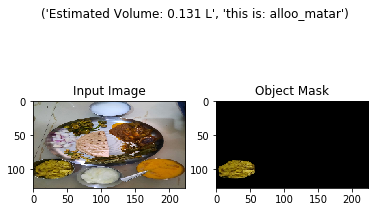

Estimated volume: 0.15962555123594974 L


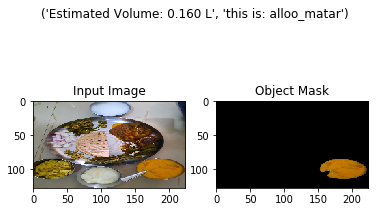

Estimated volume: 0.22819354955616078 L


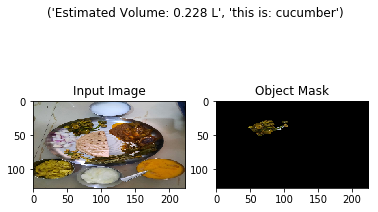

Estimated volume: 0.1806847801656778 L


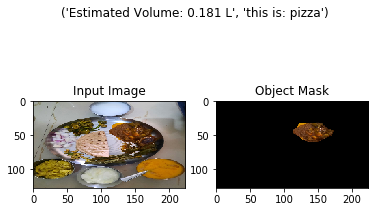

Estimated volume: 0.01510798063719453 L


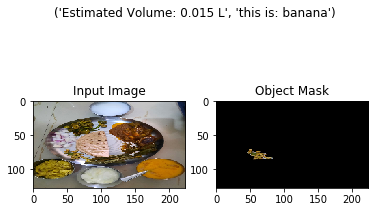

Estimated volume: 0.11054932073379352 L


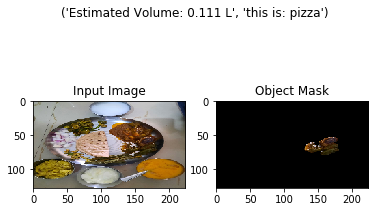

Estimated volume: 0.18738157011450376 L


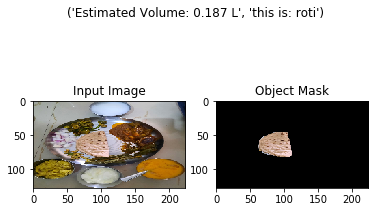

Estimated volume: 0.09062188306055854 L


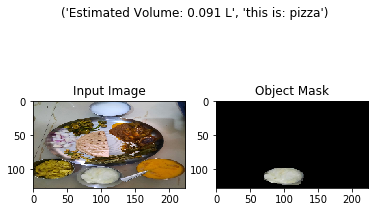

total Calories your are goint to intake is 1430.87 cal
total weight of food is 952.89 gms


({'alloo_matar': 242.52916728863784,
  'cucumber': 32.51758081175291,
  'pizza': 787.5779669175616,
  'banana': 16.900391459991287,
  'roti': 351.3404439646945},
 {'alloo_matar': 291.0466426120699,
  'cucumber': 216.78387207835272,
  'pizza': 286.3919879700224,
  'banana': 18.129576764633434,
  'roti': 140.5361775858778})

In [9]:
predict(r"C:\Users\Jay Chothani\study\TERM 3\Capstone\thali.jpg",plot_results=True)

Found 8 food object(s) in image.
Estimated volume: 0.20380987994553035 L


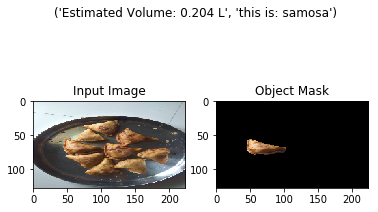

Estimated volume: 0.046439982707522615 L


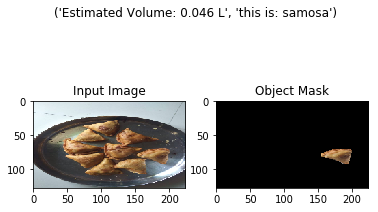

Estimated volume: 0.20311185720409264 L


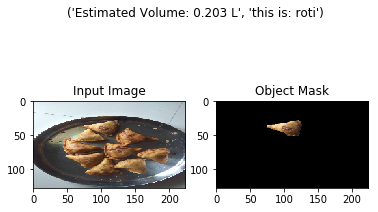

Estimated volume: 0.06206356630308667 L


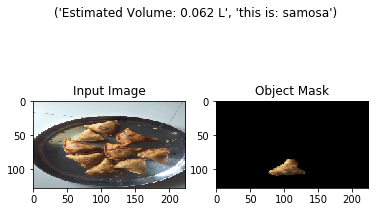

Estimated volume: 0.048022597626425884 L


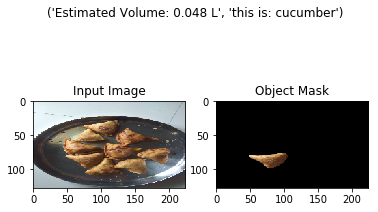

Estimated volume: 0.042395587114885364 L


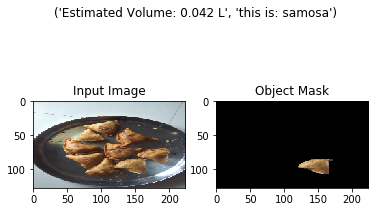

Estimated volume: 0.07374488570858684 L


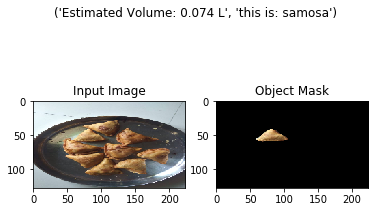

Estimated volume: 0.11010809030831709 L


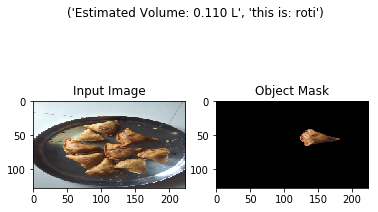

total Calories your are goint to intake is 2136.56 cal
total weight of food is 794.68 gms


({'samosa': 1542.4340464066024,
  'roti': 587.2874015857683,
  'cucumber': 6.843220161765688},
 {'samosa': 514.1446821355341,
  'roti': 234.9149606343073,
  'cucumber': 45.62146774510458})

In [10]:
predict(r"C:\Users\Jay Chothani\study\TERM 3\Capstone\samosa.jpg",plot_results=True)

Found 8 food object(s) in image.
Estimated volume: 0.20380987994553035 L


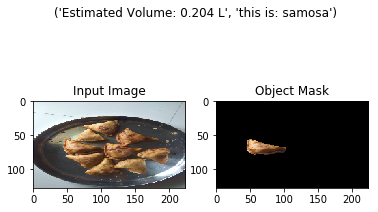

Estimated volume: 0.046439982707522615 L


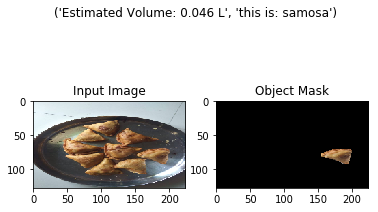

Estimated volume: 0.20311185720409264 L


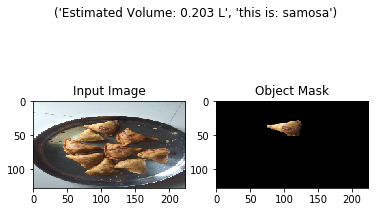

Estimated volume: 0.06206356630308667 L


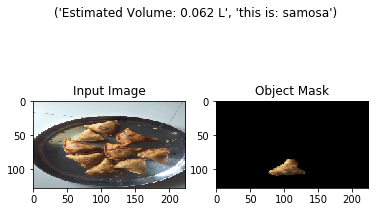

Estimated volume: 0.048022597626425884 L


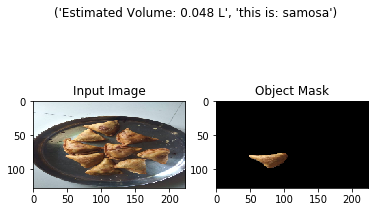

Estimated volume: 0.042395587114885364 L


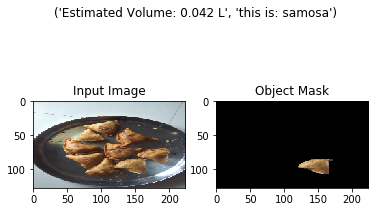

Estimated volume: 0.07374488570858684 L


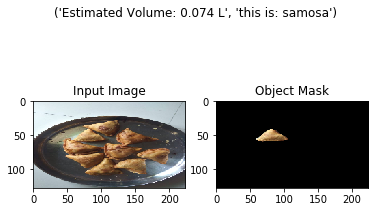

Estimated volume: 0.11010809030831709 L


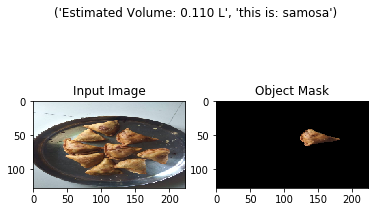

total Calories your are goint to intake is 2842.91 cal
total weight of food is 947.64 gms


({'samosa': 2842.907208906411}, {'samosa': 947.6357363021368})

In [10]:
predict(r"C:\Users\Jay Chothani\study\TERM 3\Capstone\samosa.jpg",plot_results=True,food = "samosa")

Found 6 food object(s) in image.
Estimated volume: 0.7076971853827299 L


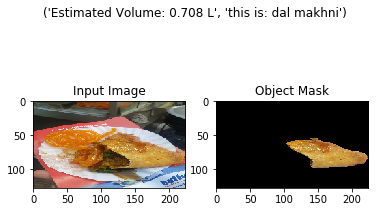

Estimated volume: 0.04433146642960965 L


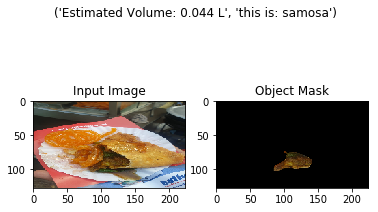

Estimated volume: 0.10355402138159346 L


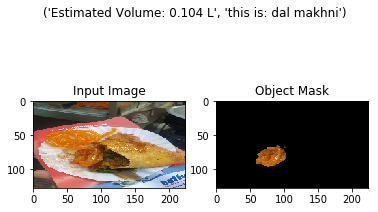

Estimated volume: 1.1764725488621652 L


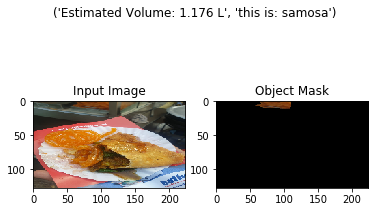

Estimated volume: 0.023730835973737496 L


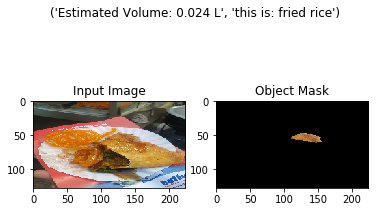

Estimated volume: 0.2425842902875144 L


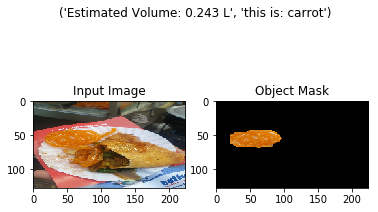

total Calories your are goint to intake is 6108.62 cal
total weight of food is 2645.54 gms


({'dal makhni': 1561.6585730213228,
  'samosa': 4394.894455050389,
  'fried rice': 42.71550475272749,
  'carrot': 109.35214637580575},
 {'dal makhni': 892.3763274407559,
  'samosa': 1464.96481835013,
  'fried rice': 21.357752376363745,
  'carrot': 266.84271931626586})

In [11]:
predict(r"C:\Users\Jay Chothani\study\TERM 3\Capstone\jalebi samosa.jpg",plot_results=True)

Found 3 food object(s) in image.
Estimated volume: 0.3203105417733684 L


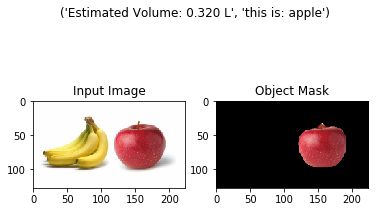

Estimated volume: 0.13088564813849296 L


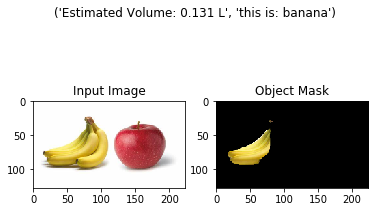

Estimated volume: 0.10270123133134401 L


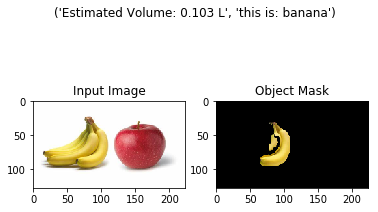

total Calories your are goint to intake is 411.75 cal
total weight of food is 568.58 gms


({'apple': 150.45306457636883, 'banana': 261.2996268501384},
 {'apple': 288.2794875960315, 'banana': 280.3042553638043})

In [13]:
predict(r'C:\Users\Jay Chothani\study\TERM 3\Capstone\th (4).jpeg',plot_results=True)

Found 3 food object(s) in image.
Estimated volume: 0.38121373887695137 L


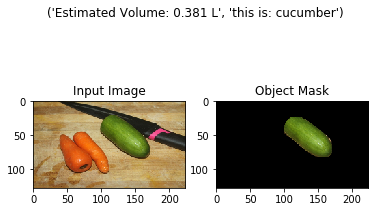

Estimated volume: 0.11217929800796388 L


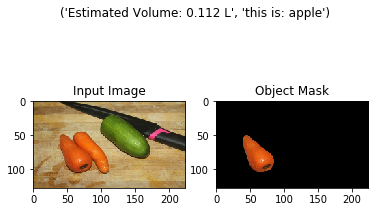

Estimated volume: 0.12232601595199742 L


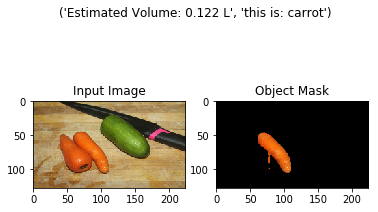

total Calories your are goint to intake is 162.16 cal
total weight of food is 597.67 gms


({'cucumber': 54.322957789965564,
  'apple': 52.691738067320706,
  'carrot': 55.1421214708414},
 {'cucumber': 362.15305193310377,
  'apple': 100.96136820716748,
  'carrot': 134.55861754719717})

In [14]:
predict(r"C:\Users\Jay Chothani\study\TERM 3\Capstone\roti\IMG_8158.jpg",plot_results=True)

Found 3 food object(s) in image.
Estimated volume: 0.33830374623939286 L


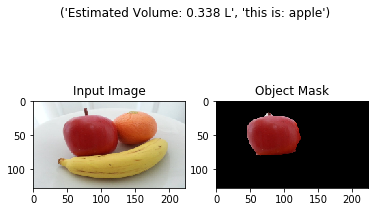

Estimated volume: 0.35644582342956704 L


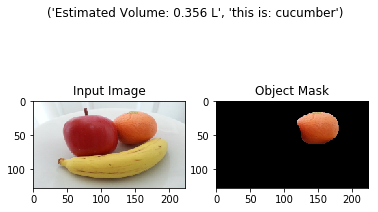

Estimated volume: 0.4097330632699042 L


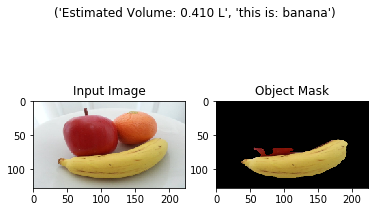

total Calories your are goint to intake is 668.04 cal
total weight of food is 1134.78 gms


({'apple': 158.9046526461052,
  'cucumber': 50.793529838713305,
  'banana': 458.3437938962456},
 {'apple': 304.4733716154536,
  'cucumber': 338.6235322580887,
  'banana': 491.67967592388504})

In [15]:
predict(r"C:\Users\Jay Chothani\study\TERM 3\Capstone\roti\apple orrange banana.jpg",plot_results=True)

C:\Users\Jay Chothani\.conda\envs\food_volume_estimmation\lib\site-packages\food_volume_estimation-0.3-py3.6.egg\food_volume_estimation\ellipse_detection\ellipse_estimator.py:71: RuntimeWarning: invalid value encountered in double_scalars


Found 4 food object(s) in image.
Estimated volume: 0.4962218087262453 L


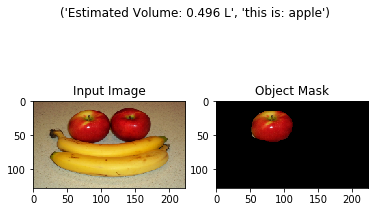

Estimated volume: 0.49541108031928277 L


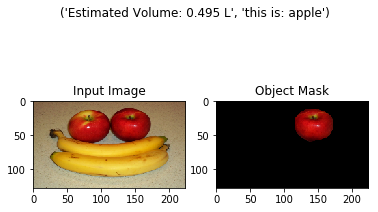

Estimated volume: 1.0218354121019877 L


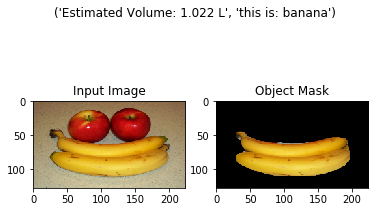

Estimated volume: 0.12292749464941648 L


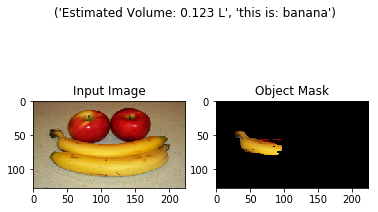

total Calories your are goint to intake is 1746.36 cal
total weight of food is 2266.19 gms


({'apple': 465.77988431357494, 'banana': 1280.5775780083904},
 {'apple': 892.4696001409752, 'banana': 1373.715488101685})

In [16]:
predict(r"C:\Users\Jay Chothani\study\TERM 3\Capstone\roti\apples-and-bananas.jpg",plot_results=True)

Found 1 food object(s) in image.
Estimated volume: 0.21347775359292342 L


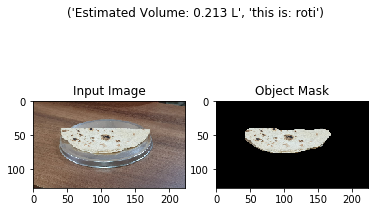

total Calories your are goint to intake is 400.27 cal
total weight of food is 160.11 gms


({'roti': 400.2707879867314}, {'roti': 160.10831519469258})

In [19]:
predict(r"C:\Users\Jay Chothani\study\TERM 3\Capstone\roti\halfroti.jpg",plot_results=True)

Found 1 food object(s) in image.
Estimated volume: 2.063832990731597 L


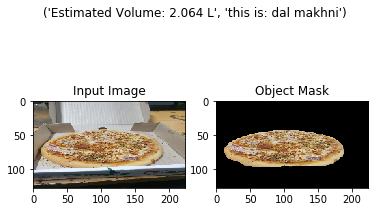

total Calories your are goint to intake is 3972.88 cal
total weight of food is 2270.22 gms


({'dal makhni': 3972.8785071583243}, {'dal makhni': 2270.216289804757})

In [20]:
predict(r"C:\Users\Jay Chothani\study\TERM 3\Capstone\lapinoz.jpg",plot_results=True)

C:\Users\Jay Chothani\.conda\envs\food_volume_estimmation\lib\site-packages\food_volume_estimation-0.3-py3.6.egg\food_volume_estimation\ellipse_detection\ellipse_center_estimator.py:84: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\Jay Chothani\.conda\envs\food_volume_estimmation\lib\site-packages\food_volume_estimation-0.3-py3.6.egg\food_volume_estimation\ellipse_detection\ellipse_center_estimator.py:85: RuntimeWarning: divide by zero encountered in double_scalars


Found 1 food object(s) in image.
Estimated volume: 1.1415113818553615 L


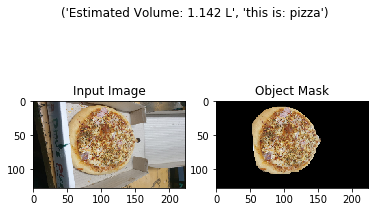

total Calories your are goint to intake is 2354.37 cal
total weight of food is 856.13 gms


({'pizza': 2354.3672250766836}, {'pizza': 856.1335363915211})

In [21]:
predict(r"C:\Users\Jay Chothani\study\TERM 3\Capstone\lapinoz.jpg",plot_results=True)

C:\Users\Jay Chothani\.conda\envs\food_volume_estimmation\lib\site-packages\food_volume_estimation-0.3-py3.6.egg\food_volume_estimation\ellipse_detection\ellipse_center_estimator.py:84: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\Jay Chothani\.conda\envs\food_volume_estimmation\lib\site-packages\food_volume_estimation-0.3-py3.6.egg\food_volume_estimation\ellipse_detection\ellipse_center_estimator.py:85: RuntimeWarning: divide by zero encountered in double_scalars


[*] Ellipse parameters: (155.22116088867188, 66.30769348144531, 76.0, 36.84848484848485, -0.46509611910686877)
Found 2 food object(s) in image.
Estimated volume: 0.3230251220025985 L


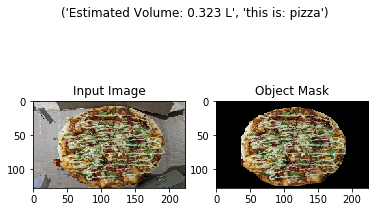

Estimated volume: 0.00034168818018541594 L


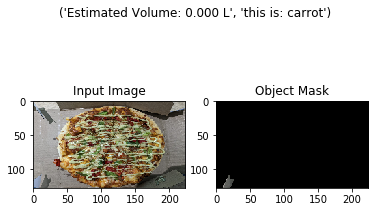

total Calories your are goint to intake is 666.24 cal
total weight of food is 242.27 gms


({'pizza': 666.2393141303592}, {'pizza': 242.26884150194883})

In [24]:
predict(r"C:\Users\Jay Chothani\study\TERM 3\Capstone\WhatsApp Image 2023-04-08 at 15.12.54.jpg",plot_results=True,dia=0.25)

Found 10 food object(s) in image.
Estimated volume: 0.18329160820330956 L


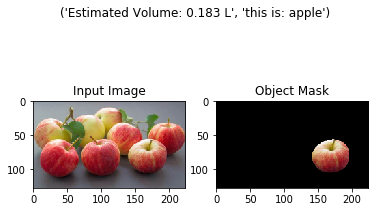

Estimated volume: 0.23396064087278728 L


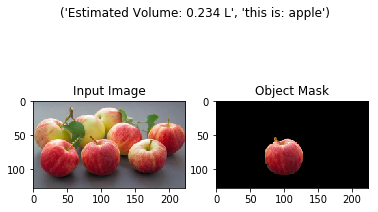

Estimated volume: 0.2994094035621329 L


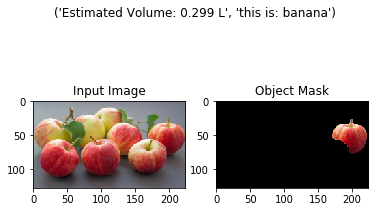

Estimated volume: 0.18274974655449608 L


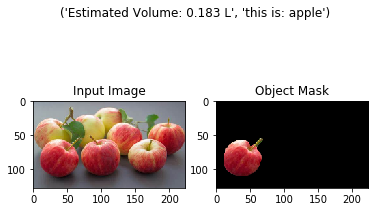

Estimated volume: 0.20406503954247596 L


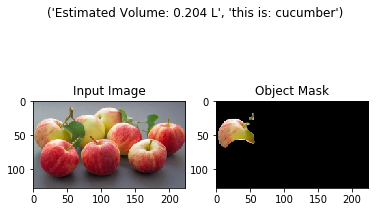

Estimated volume: 0.18835477598243863 L


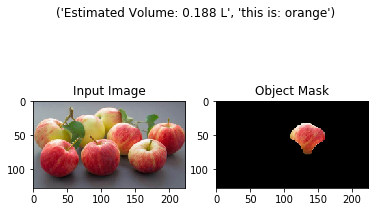

Estimated volume: 0.14193230579344487 L


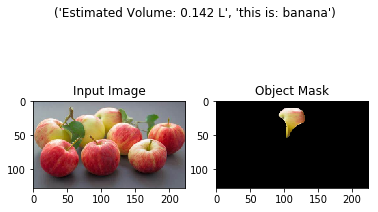

Estimated volume: 0.21205763603475214 L


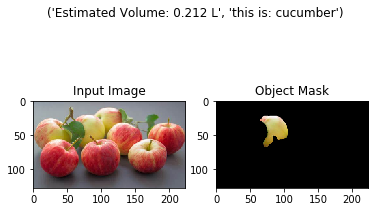

Estimated volume: 0.03566041952060753 L


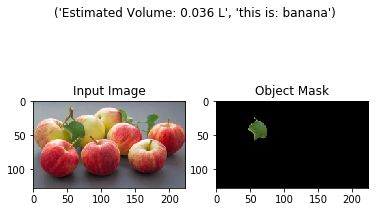

Estimated volume: 0.03527051478268097 L


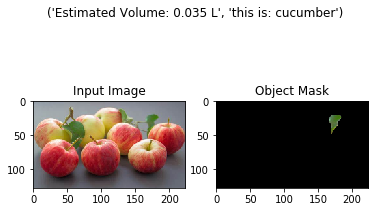

total Calories your are goint to intake is 955.26 cal
total weight of food is 1720.16 gms


({'apple': 281.8269373676458,
  'banana': 533.593661446056,
  'cucumber': 64.32352962628704,
  'orange': 75.51142969135965},
 {'apple': 540.0017960675336,
  'banana': 572.4025546514223,
  'cucumber': 428.82353084191357,
  'orange': 178.9370371833167})

In [25]:
predict(r"C:\Users\Jay Chothani\study\TERM 3\Capstone\roti\OIP.jpg",plot_results=True)

Found 10 food object(s) in image.
Estimated volume: 0.18329160820330956 L


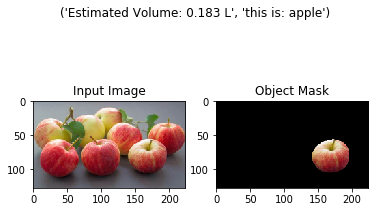

Estimated volume: 0.23396064087278728 L


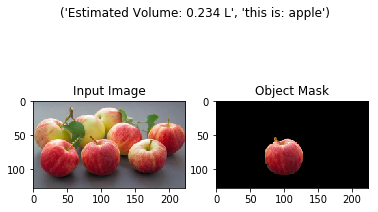

Estimated volume: 0.2994094035621329 L


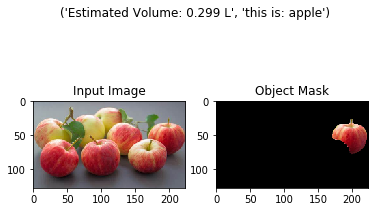

Estimated volume: 0.18274974655449608 L


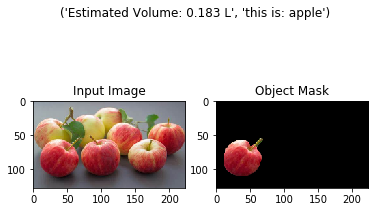

Estimated volume: 0.20406503954247596 L


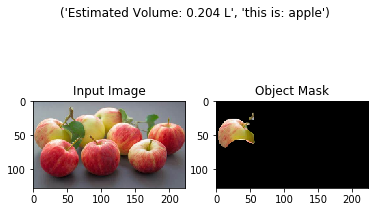

Estimated volume: 0.18835477598243863 L


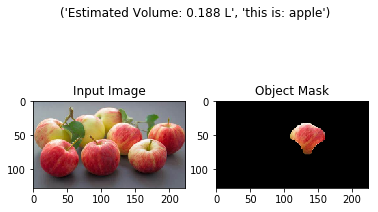

Estimated volume: 0.14193230579344487 L


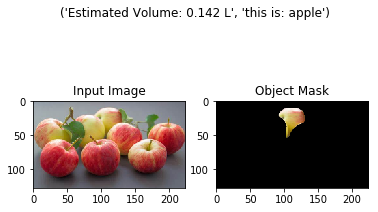

Estimated volume: 0.21205763603475214 L


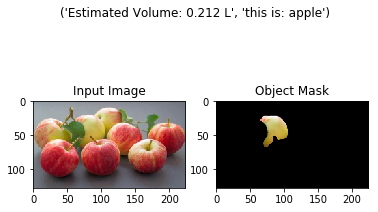

Estimated volume: 0.03566041952060753 L


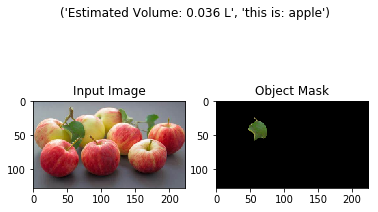

Estimated volume: 0.03527051478268097 L


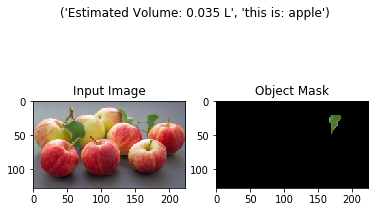

total Calories your are goint to intake is 806.38 cal
total weight of food is 1545.08 gms


({'apple': 806.3756245927428}, {'apple': 1545.0768817642136})

In [26]:
predict(r"C:\Users\Jay Chothani\study\TERM 3\Capstone\roti\OIP.jpg",plot_results=True,food="apple")

[*] Ellipse parameters: (74.5904312133789, 64.67214965820312, 53.0, 40.686868686868685, 0.043876992368572676)
Found 2 food object(s) in image.
Estimated volume: 0.20746005868422607 L


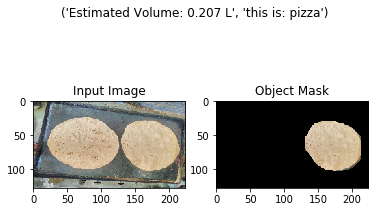

Estimated volume: 0.3285658314121359 L


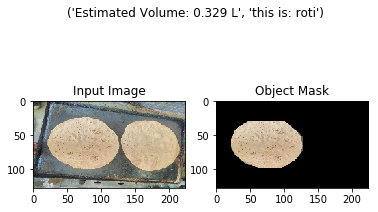

total Calories your are goint to intake is 1043.95 cal
total weight of food is 402.02 gms


({'pizza': 427.88637103621625, 'roti': 616.0609338977548},
 {'pizza': 155.59504401316954, 'roti': 246.42437355910195})

In [35]:
predict(r"C:\Users\Jay Chothani\study\TERM 3\Capstone\roti\IMG-20190310-WA0023.jpg",plot_results=True,dia=0.20)

In [ ]:
predict(r"C:\Users\Jay Chothani\study\TERM 3\Capstone\roti\IMG_20190724_185438.jpg",plot_results=True)

In [ ]:
predict(r"C:\Users\Jay Chothani\study\TERM 3\Capstone\roti\IMG_20190724_185438.jpg")